In [1]:
from math import sqrt
from operator import itemgetter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn import metrics


In [2]:
class CollaborativeFilter:
    def __init__(self, records_train, records_test):
        records = np.vstack([records_train, records_test])
        n = len(np.unique(np.sort(records[:, 0])))
        m = len(np.unique(np.sort(records[:, 1])))

        # Initial R
        R = np.zeros([n, m], dtype=np.int32)
        self.R = R
        self.n = n
        for record in records_train:
            R[record[0], record[1]] = record[2]

        # Initial indicator
        y = np.where(R, 1, 0)
        y_user = np.sum(y, axis=1)
        y_item = np.sum(y, axis=0)

        # Global average of rating
        self.r = np.sum(R) / np.sum(y)

        # average rating of user
        self.r_u = np.where(y_user,
                            np.sum(R, axis=1) / y_user,
                            self.r)

        # average rating of item
        self.r_i = np.where(y_item,
                            np.sum(R, axis=0) / y_item,
                            self.r)

        # Calculate similarity of users
        self.s_u = np.zeros([n, n])
        for u in range(n):
            for w in range(u):
                items = (R[u, :] != 0) * (R[w, :] != 0)
                if items.sum() == 0:
                    continue
                vec_u = R[u, items] - self.r_u[u]
                vec_w = R[w, items] - self.r_u[w]
                dot = vec_u.dot(vec_w)
                mag_vec_u = sqrt(np.square(vec_u).sum())
                mag_vec_w = sqrt(np.square(vec_w).sum())
                if mag_vec_u == 0 or mag_vec_w == 0:
                    continue
                similarity = dot / mag_vec_u / mag_vec_w

                self.s_u[u, w] = self.s_u[w, u] = similarity
            
            
        # Calculate similarity of items
        self.s_i = np.zeros([m, m])
        for i in range(m):
            for j in range(i):
                users = (R[:, i] != 0) * (R[:, j] != 0)
                if users.sum() == 0:
                    continue
                vec_i = R[users, i] - self.r_u[users]
                vec_j = R[users, j] - self.r_u[users]

                dot = vec_i.dot(vec_j)
                mag_vec_i = sqrt(np.square(vec_i).sum())
                mag_vec_j = sqrt(np.square(vec_j).sum())
                if mag_vec_i == 0 or mag_vec_j == 0:
                    continue
                similarity = dot / mag_vec_i / mag_vec_j

                self.s_i[i, j] = self.s_i[j, i] = similarity
        
            
    def user_based_performance(self, records_test, K):
        ratings_predict = np.zeros([len(records_test), 1])
        for i in range(len(records_test)):
            user = records_test[i, 0]
            item = records_test[i, 1]

            # Neighbours
            neighbours = np.intersect1d(np.where(self.s_u[user, :] > 0)[0], np.where(self.R[:, item] != 0)[0])

            # have zero neighbour who has rated this item
            if len(neighbours) == 0:
                ratings_predict[i] = self.r_u[user]
                continue

            # sort by similarity and select K of them
            neighbours_aug = np.vstack([neighbours, self.s_u[user, neighbours]])
            neighbours = neighbours[np.argsort(neighbours_aug[1, :])[-K:]]

            # predict
            ratings_predict[i] = (self.R[neighbours, item] - self.r_u[neighbours]).dot(self.s_u[user, neighbours])
            ratings_predict[i] /= np.abs(self.s_u[user, neighbours]).sum()
            ratings_predict[i] += self.r_u[user]

        return ratings_predict

    def item_based_performance(self, records_test, K):
        ratings_predict = np.zeros([len(records_test), 1])
        for i in range(len(records_test)):
            user = records_test[i, 0]
            item = records_test[i, 1]

            # Neighbours
            neighbours = np.intersect1d(np.where(self.s_i[:, item] > 0)[0], np.where(self.R[user, :] != 0)[0])

            # have zero neighbour which was rated by the user
            if len(neighbours) == 0:
                ratings_predict[i] = self.r_u[user]
                continue

            # sort by similarity and select K of them
            neighbours_aug = np.vstack([neighbours, self.s_i[item, neighbours]])
            neighbours = neighbours[np.argsort(neighbours_aug[1, :])[-K:]]

            # predict
            ratings_predict[i] = self.R[user, neighbours].dot(self.s_i[item, neighbours])
            ratings_predict[i] /= np.abs(self.s_i[item, neighbours]).sum()

        return ratings_predict
    

In [3]:
def score(rating_test, rating_predict):
    return [round(sqrt(metrics.mean_squared_error(rating_test, rating_predict)), 4),
            round(metrics.mean_absolute_error(rating_test, rating_predict), 4)]

In [4]:
# Load the records
records_train = np.loadtxt('../data/ml-100k/u1.base', dtype=np.int32)
records_test = np.loadtxt('../data/ml-100k/u1.test', dtype=np.int32)

# Preprocess
records_train[:, :2] -= 1
records_test[:, :2] -= 1
ratings_test = records_test[:, 2]
records = np.vstack([records_train, records_test])

In [5]:
%%time
threshold = 0
K = 50
usercf = CollaborativeFilter(records_train, records_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 49.4 s, sys: 64.2 ms, total: 49.5 s
Wall time: 49.5 s


In [6]:
%%time
ratings_predict_user_based = usercf.user_based_performance(records_test, K)
print(score(np.clip(ratings_predict_user_based, 1, 5), ratings_test))

[0.9554, 0.748]
CPU times: user 1.93 s, sys: 4.97 ms, total: 1.93 s
Wall time: 1.93 s


In [8]:
%%time
ratings_predict_item_based = usercf.item_based_performance(records_test, K)

print(score(np.clip(ratings_predict_item_based, 1, 5), ratings_test))

[0.9885, 0.7791]
CPU times: user 2.1 s, sys: 5.27 ms, total: 2.1 s
Wall time: 2.1 s


In [12]:
print(score(np.clip((ratings_predict_item_based + ratings_predict_user_based) / 2, 1, 5), ratings_test))

[0.9559, 0.7526]


In [13]:
results = np.array([score(np.clip(ratings_predict_user_based, 1, 5), ratings_test),
                    score(np.clip(ratings_predict_item_based, 1, 5), ratings_test),
                    score(np.clip((ratings_predict_item_based + ratings_predict_user_based) / 2, 1, 5), ratings_test)])

In [14]:
results

array([[0.9554, 0.748 ],
       [0.9885, 0.7791],
       [0.9559, 0.7526]])

(-0.05, 1.05)


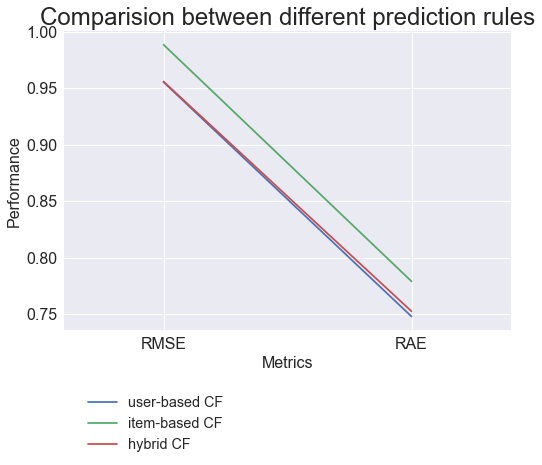

In [15]:
# Plot the figure
metrics = ['RMSE', 'RAE']
labels = ['user-based CF', 'item-based CF', 'hybrid CF']
plt.style.use('seaborn')
fig, ax = plt.subplots()

for result, label in zip(results, labels):
    ax.plot(metrics, result, label=label)

ax.legend(fontsize="x-large", loc=2, bbox_to_anchor=(0.04 ,-0.2),borderaxespad = 0.) 
x_major_locator= MultipleLocator(1)

ax.xaxis.set_major_locator(x_major_locator)

# Format plot
plt.title("Comparision between different prediction rules", fontsize=24)
plt.xlabel('Metrics', fontsize=16)
plt.ylabel("Performance", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

print(plt.xlim())

plt.xlim(-0.4, 1.4)

plt.show()

